# Exploring Cellular Protein Localization Through Semantic Image Synthesis

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils
from torch.nn.utils import spectral_norm
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from torch.utils.data import DataLoader

from ds import MIBIDataset
import torch.nn.utils.spectral_norm as spectral_norm
from torch.nn.functional import normalize


from utilities import weights_init, seg_show

In [2]:
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)

torch.cuda.set_device(0)
gpu_available = True
channel_names = ["Pan-Keratin", "EGFR", "Beta catenin", "dsDNA",
                 "Ki67", "CD3", "CD8", "CD4", "FoxP3", "MPO", "HLA-DR", 
                 "HLA_Class_1", "CD209", "CD11b",  "CD11c", "CD68", "CD63",
                 "Lag3", "PD1", "PD-L1", "IDO", "Vimentin", "SMA", "CD31"]

# Parameters

In [3]:
# Learning rate for optimizers
batch_size = 32
nz = hidden_size = 128
kernel = 3

# Number of input channels (later to be number of classes)
num_chan = 18

# Size of feature maps in discriminator
ndf = 32

# Output dimension
nc = 24

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

c24_idx = np.array(range(25))
c24_idx = np.delete(c24_idx, 4)

# Read In Data

In [ ]:
# train data
cells_seg = []
cells_real = []
keys = []

path = './data'
filelist = os.listdir(path + '/train')

for i in range(int(len(filelist[:]))): # have both counts and cells
    patch = path + '/train/cell_' + str(i) + '.npy'
    cells_seg.append(np.load(patch)[0])
    cells_real.append(np.load(patch)[1][c24_idx])

print('number of total cells: %d' % (len(cells_seg))) 

cells_seg = np.array(cells_seg)
empty = np.less(np.sum(cells_seg, axis=1, keepdims=True), 0.5).astype(np.float32)
cells_seg = np.concatenate([cells_seg, empty], axis=1)


cells_real = np.array(cells_real) 
cells = np.array([[cells_seg[i], cells_real[i]] for i in range(len(cells_seg))])

train_set_loader = DataLoader(MIBIDataset(cells), batch_size=batch_size, 
                       shuffle=True, num_workers=4, pin_memory=gpu_available)

In [ ]:
# test data

cells_seg = []
cells_real = []
keys = []

path = './data'
filelist = os.listdir(path + '/test')

for i in range(int(len(filelist[:]))): # have both counts and cells
    patch = path + '/test/cell_' + str(i) + '.npy'
    cells_seg.append(np.load(patch)[0])
    cells_real.append(np.load(patch)[1][c24_idx])

print('number of total cells: %d' % (len(cells_seg))) 


cells_seg = np.array(cells_seg)
empty = np.less(np.sum(cells_seg, axis=1, keepdims=True), 0.5).astype(np.float32)
cells_seg = np.concatenate([cells_seg, empty], axis=1)

cells_real = np.array(cells_real)
cells = np.array([[cells_seg[i], cells_real[i]] for i in range(len(cells_seg))])

test_set_loader =  DataLoader(MIBIDataset(cells), batch_size=1, 
                       shuffle=True, num_workers=4, pin_memory=gpu_available)


# Spade

In [5]:
# kind of batch normalization, k should have same size with input channels

class SPADE(nn.Module):
    def __init__(self, input_size, filters=128, kernel_size=3, num_chan=num_chan):
        super().__init__()
        
        output_size = input_size
        self.conv = nn.Conv2d(num_chan, filters, kernel_size=(kernel_size, kernel_size), 
                                padding=1)
        self.conv_gamma = nn.Conv2d(filters, output_size, kernel_size=(kernel_size, kernel_size), 
                                padding=1)
        self.conv_beta = nn.Conv2d(filters, output_size, kernel_size=(kernel_size, kernel_size), 
                                padding=1)
        self.norm = nn.InstanceNorm2d(output_size, affine=False)
        
    def forward(self, x, seg):

        N, C, H, W = x.size()
        x = self.norm(x)
        seg = F.interpolate(seg, size=(H,W), mode='nearest')
        shared = F.relu(self.conv(seg))
        seg_gamma = self.conv_gamma(shared)
        seg_beta = self.conv_beta(shared)
        self.plot = seg_gamma
        x = x * (1 + seg_gamma) + seg_beta
        return x

# Generator

In [6]:
class ResnetBlock(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size=3):
        super(ResnetBlock, self).__init__()
        
        self.if_shortcut = (dim_in != dim_out)
        dim_middle = min(dim_in, dim_out)
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels=dim_in, out_channels=dim_middle,
                                   kernel_size=kernel_size, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(in_channels=dim_middle, out_channels=dim_out,
                                   kernel_size=kernel_size, padding=1))
        
        if self.if_shortcut:
            self.convs = spectral_norm(nn.Conv2d(dim_in, dim_out, kernel_size=1, bias=False))

        self.norm1 = SPADE(dim_in)
        self.norm2 = SPADE(dim_middle)
        if self.if_shortcut:
            self.norms = SPADE(dim_in)

    def forward(self, x, seg):

        xs = self.shortcut(x, seg)

        dx = self.conv1(self.actvn(self.norm1(x, seg)))
        dx = self.conv2(self.actvn(self.norm2(dx, seg)))

        out = xs + dx

        return out
        
        
    def shortcut(self, x, seg):
        if self.if_shortcut:
            xs = self.convs(self.norms(x, seg))
        else:
            xs = x
        return xs
    
    def actvn(self, x):
        return F.leaky_relu(x, 0.2)     


In [7]:
class Modulation(nn.Module):
    def __init__(self, num_chan=num_chan,
                    nc=nc):
        super().__init__()
        self.K = 8
        self.num_chan = num_chan
        self.nc = nc # output channels
        self.states = nn.ParameterList([nn.Parameter(torch.FloatTensor(
                            0.02 * torch.rand(1, self.K))) for _ in range(self.nc)])
        self.f = nn.Conv2d(8*self.K, 1, kernel_size=1, stride=1, padding=0, bias=False)
        self.act = nn.LeakyReLU()
        
    
    def forward(self, wspade, nc, seg):

        curr_batch_size = wspade.size(0)
        c_state = self.states[nc].expand([curr_batch_size, self.K])
        out = torch.einsum('bchw,bk->bckhw', wspade, c_state)
        out = torch.reshape(out, [curr_batch_size, self.K * 8, 64, 64])
        out = nn.Sigmoid()(self.f(out)) # 32, 1, 64, 64
        return out
        

In [9]:
class ChannelGenerator(nn.Module):
    def __init__(self,
                num_chan = num_chan,
                nc = nc, n_attmap=3):
        super().__init__()
                
        self.n_attmap = n_attmap
        self.nc = nc
        self.ups = nn.Upsample(scale_factor=2, mode='nearest')
        self.modulation = Modulation()
        
        self.linear = nn.Linear(128, 2048)
        self.resblk_1 = ResnetBlock(128,  128)   # (8,8)
        self.resblk_2 = ResnetBlock(128,  128)   # (16,16)
        self.resblk_3 = ResnetBlock(128,  64)    # (32,32)
        self.resblk_4 = ResnetBlock(64,  64)     # (64,64)
        
        self.conv = spectral_norm(nn.Conv2d(64, nc, kernel_size=5, 
                                            padding=2, padding_mode="reflect"))
        
        self.conv_group = spectral_norm(nn.Conv2d(64, nc * 8, kernel_size=5, 
                                             padding=2, padding_mode="reflect"))
        
        self.spade_group = []
        self.residuals = 0
        
        for i in range(nc):
            self.spade_group.append(SPADE(8, filters=64).cuda())
        
    def forward(self, x, seg):

        curr_size = x.size(0)

        x = self.linear(x)
        x = x.view(-1, 128, 4 ,4)
        
        x = self.ups(x)
        x = self.resblk_1(x,seg)
        
        x = self.ups(x)
        x = self.resblk_2(x,seg)
        
        x = self.ups(x)
        x = self.resblk_3(x,seg)
        
        x = self.ups(x)
        x = self.resblk_4(x,seg)
        
        self.px = self.conv(F.leaky_relu(x, 0.2))
        x =  self.conv_group(F.leaky_relu(x, 0.2))
        out = x.clone()
        ret = []
        
        for i in range(nc):
            modded = self.spade_group[i](x[:,i*8:(i+1)*8], seg)
            ret.append(self.modulation(modded, i, seg))
            
        ret = torch.stack(ret, dim=1).squeeze()
        self.residuals = ret
        ret = ret + self.px
        return nn.Sigmoid()(ret)

# Discriminator

In [10]:
class DiscriminatorBase(nn.Module):
    def __init__(self,
                 ndf=ndf, 
                 num_chan=num_chan, 
                 batch_size=batch_size,
                 nz=nz,
                 nc=nc):
        super(DiscriminatorBase, self).__init__()

        self.layer1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(num_chan + nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer4 = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer5 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, ndf * 16, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=False))
            
        
        self.layer6 = nn.Sequential(
            # state size. (ndf*16) x 2 x 2
            nn.Conv2d(ndf * 16, 1, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.feature_maps = []
        
    def forward(self, input, X_seg):
        
        x = torch.cat([input, X_seg], dim=1)
        
        x = self.layer1(x)
        self.feature_maps.append(x)
        
        x = self.layer2(x)
        self.feature_maps.append(x)
        
        x = self.layer3(x)
        self.feature_maps.append(x)
        
        x = self.layer4(x)
        self.feature_maps.append(x)
        
        x = self.layer5(x)
        self.feature_maps.append(x)
        
        x = self.layer6(x)
        
        return x
    
    def reset(self):
        self.feature_maps = []


# Training

In [ ]:
netG = ChannelGenerator().float().cuda()
netD = DiscriminatorBase().float().cuda()

optimizerG = optim.Adam(netG.parameters(), lr=0.0004)
optimizerD = optim.Adam(netD.parameters(), lr=0.0001)

netG.apply(weights_init)
netD.apply(weights_init)

# Initialize loss functions
criterionG = nn.MSELoss()
criterionD = nn.MSELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

print("Initialized")

In [ ]:
# Training Loop
num_epochs = 120

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
R_losses = []
iters = 0

d_iters = 1
g_iters = 1

print("Starting Training Loop...")
# For each epoch
for epoch in range(1, num_epochs):
    if epoch % 100 == 0:
        for param_group in optimizerG.param_groups:
                param_group['lr'] /= 2
        for param_group in optimizerD.param_groups:
                param_group['lr'] /= 2
                
                
    for idx, data in enumerate(train_set_loader):
        
        X_seg, X_real = data
        X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
        X_real = X_real.transpose(2,1).float().cuda()

        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        for _ in range(d_iters):
            netD.zero_grad()
            
            output = netD(X_real, X_seg)
            label = torch.full(output.size(), real_label).cuda()
            
            errD_real = criterionD(output, label)
            errD_real.backward()
            
            D_x = output.mean().item()
            
            noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
            fake = netG(noise, X_seg.detach())
            label.fill_(fake_label)
            output = netD(fake.detach(), X_seg.detach())
            errD_fake = criterionD(output, label)
            errD_fake.backward()
            
            D_G_z1 = output.mean().item()

            errD = errD_real + errD_fake 
            
            optimizerD.step()
                
            netD.zero_grad()
            netD.reset()
            
        for _ in range(g_iters):
            netG.zero_grad()
            
            fake = netG(noise, X_seg.detach())
            label.fill_(real_label)
            
            output = netD(fake, X_seg.detach())
            errG = criterionD(output, label)
            D_fm_fake = netD.feature_maps   # fake feature map
            netD.reset()
            
            output_real = netD(X_real.detach(), X_seg.detach()).view(-1)
            D_fm_real = netD.feature_maps   # real feature map
            netD.reset()
            
            D_fm_loss = 0
            for i in range(len(D_fm_fake)):
                D_fm_loss += nn.L1Loss()(D_fm_fake[i], D_fm_real[i])
               
            r_loss = D_fm_loss
            Lambda = 10
            errG += Lambda*D_fm_loss
            
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            
            
            
        if idx % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_R: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, idx, len(train_set_loader),
                     errD.item(), errG.item(), r_loss.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
    if epoch % 5 == 1:

        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("residuals: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(netG.residuals.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest',
                      norm=normalize)
        plt.show()
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("px: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(netG.px.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(2.5, 2.5))
        print("Segmentation: ")
        plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Fake: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Real: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow( X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Fake Scaled: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Real Scaled: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()


    if epoch % 20 == 1:
        print("============================")
        print("test cell")
        print("============================")
        
        for idx, data in enumerate(test_set_loader):
        
            X_seg, X_real = data
            X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
            X_real = X_real.transpose(2,1).float().cuda()
            noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
            break
        
        
        fake = netG(noise, X_seg.detach())
        
        fig=plt.figure(figsize=(2.5, 2.5))
        print("Segmentation: ")
        plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
        plt.show()
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Fake: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Real: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow( X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Fake Scaled: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Real Scaled: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()


# Save & Load Model

In [ ]:
state = {
    'epoch': epoch,
    'G': netG.state_dict(),
    'optimizerG': optimizerG.state_dict(),
    'D' : netD.state_dict(),
    'optimizerD' : optimizerD.state_dict()
}
torch.save(state, './model/ccigan')

In [ ]:
netG = ChannelGenerator().float().cuda()
state = torch.load('./model/ccigan')
netG.load_state_dict(state['G'])

# Uncertainty Map

In [ ]:
for idx, data in enumerate(test_set_loader):
    
    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()
    noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()

    if idx == 54:
        break
    
print("cell ",idx)
plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
plt.axis('off')
plt.show()

In [32]:
K = 100
uncertainty = np.zeros([K, nc, 64, 64])
for k in range(K):
    noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
    fake = netG(noise, X_seg.detach()).detach().cpu().numpy()[0]
    uncertainty[k] = fake
    
uncert_map = uncertainty.var(axis=0)

In [ ]:
fig=plt.figure(figsize=(2.5, 2.5))
print("Segmentation: ")
plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
plt.show()


fig=plt.figure(figsize=(16, 10))
columns = 7
rows = 4
print("Fake: ")
for i in range(24):
    fig.add_subplot(rows, columns, i+1)
    plt.title(channel_names[i])
    plt.imshow(uncert_map[i],cmap='hot', interpolation='nearest')
    # plt.imshow(uncert_map[i])
plt.show()


# Interpretablity: Pan-Keratin/ CD8

In [ ]:
noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()

for idx, data in enumerate(test_set_loader):
    
    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()

    fake = netG(noise, X_seg.detach())

    if idx == 295:
        break

plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
plt.axis('off')
plt.show()

plt.imshow(fake.detach().cpu().numpy()[0][0], cmap='hot', interpolation='nearest')
plt.axis('off')
plt.show()

plt.imshow(fake.detach().cpu().numpy()[0][6], cmap='hot', interpolation='nearest')
plt.axis('off')
plt.show()


print('PK:', fake.detach().cpu().numpy()[0][0].sum())
print('cd8:', fake.detach().cpu().numpy()[0][6].sum())

In [20]:
print(netG.modulation.states[0])
print(netG.modulation.states[6])
dsdna = netG.modulation.states[0]
netG.modulation.states[0] = netG.modulation.states[6]
netG.modulation.states[6] = dsdna

Parameter containing:
tensor([[-0.8693,  0.8468, -0.1405,  0.8943,  0.7820,  0.3603, -0.7522, -0.6806]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.6901, -0.7656,  1.1423, -0.8633,  0.7656, -1.1322,  0.8298,  1.0251]],
       device='cuda:0', requires_grad=True)


In [21]:
print(netG.modulation.states[0])
print(netG.modulation.states[6])

Parameter containing:
tensor([[-0.6901, -0.7656,  1.1423, -0.8633,  0.7656, -1.1322,  0.8298,  1.0251]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.8693,  0.8468, -0.1405,  0.8943,  0.7820,  0.3603, -0.7522, -0.6806]],
       device='cuda:0', requires_grad=True)


In [ ]:
noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()

for idx, data in enumerate(test_set_loader):
    
    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()

    fake = netG(noise, X_seg.detach())

    if idx == 295:
        break

plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
plt.axis('off')
plt.show()

plt.imshow(fake.detach().cpu().numpy()[0][0], cmap='hot', interpolation='nearest')
plt.axis('off')
plt.show()

plt.imshow(fake.detach().cpu().numpy()[0][6], cmap='hot', interpolation='nearest')
plt.axis('off')
plt.show()

print('PK:', fake.detach().cpu().numpy()[0][0].sum())
print('cd8:', fake.detach().cpu().numpy()[0][6].sum())

# Interpretablity: dsDNA / HLA

In [ ]:
for idx, data in enumerate(test_set_loader):
    
    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()

    fake = netG(noise, X_seg.detach())

    if idx == 125:
        break

plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
plt.axis('off')
plt.show()

plt.imshow(fake.detach().cpu().numpy()[0][3], cmap='hot', interpolation='nearest')
plt.axis('off')
plt.show()

plt.imshow(fake.detach().cpu().numpy()[0][11], cmap='hot', interpolation='nearest')
plt.axis('off')
plt.show()
print('dsDNA:', fake.detach().cpu().numpy()[0][3].sum())
print('HLA:', fake.detach().cpu().numpy()[0][11].sum())

In [ ]:
dsdna = netG.modulation.states[3]
netG.modulation.states[3] = netG.modulation.states[11]
netG.modulation.states[11] = dsdna

In [ ]:
for idx, data in enumerate(test_set_loader):
    
    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()

    fake = netG(noise, X_seg.detach())

    if idx == 125:
        break

plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
plt.axis('off')
plt.show()

plt.imshow(fake.detach().cpu().numpy()[0][3], cmap='hot', interpolation='nearest')
plt.axis('off')
plt.show()

plt.imshow(fake.detach().cpu().numpy()[0][11], cmap='hot', interpolation='nearest')
plt.axis('off')
plt.show()


print('dsDNA:', fake.detach().cpu().numpy()[0][3].sum())
print('HLA:', fake.detach().cpu().numpy()[0][11].sum())

# Persistent Vectors Visualization

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


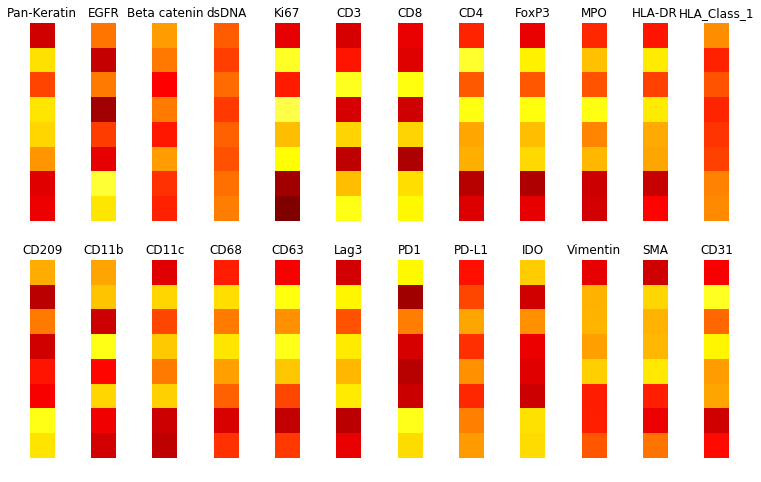

In [18]:
normalize2 = matplotlib.colors.Normalize(vmin=0, vmax=1)

fig=plt.figure(figsize=(13, 8))
columns = 12
rows = 2
for i in range(nc):
    fig.add_subplot(rows, columns, i+1)
    plt.title(channel_names[i])
    plt.imshow(F.sigmoid(netG.modulation.states[i]).cpu().detach().numpy().T, cmap='hot', norm=normalize2)
    plt.axis('off')
plt.show()

# Search Algorithm

In [12]:
# Load segmentation

cells_seg_list = []
cells_real_list = []

download_path = './data/benchmark'
filelist = os.listdir(download_path)

for i in range(len(filelist)):
    patch = download_path + '/cell_' + str(i) + '.npy'
    cells_seg_list.append(np.load(patch)[0])
    cells_real_list.append(np.load(patch)[1])

In [13]:
from scipy.stats import wasserstein_distance

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi = 2*np.pi + phi
        
    return (rho, phi)


def compute_histogram(img, divider=30, size = 64, offset=32):

    histogram = np.zeros([divider])

    for i in range(size):
        for j in range(size):
            x = j - offset
            y = offset - i
            
            rho, phi = cart2pol(x,y)
            # normalize to [0,divider]
            degree = divider * phi/(2*np.pi) 
            index = int(np.floor(degree))
            histogram[index] += img[i,j]
            
    return histogram

In [14]:
# Search Algorithm
def search_cell(seg_list, main_id, channel_id, noise, bar=0.0002):
    n_cell = len(seg_list)
    
    rand_idx = list(range(n_cell))
    
    main_id = np.random.randint(n_cell)
    rand_idx.remove(main_id)
    rand_idx = np.random.permutation(rand_idx)
    seg = 0
    # the beginning central cell
    seg += seg_list[main_id]
    empty = np.less(np.sum(seg, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_18= np.concatenate([seg, empty], axis=0)
    X_seg = torch.Tensor(seg_18).unsqueeze(0).cuda()
    fake = netG(noise, X_seg).detach().cpu().numpy()[0][channel_id]
    fake = fake*(seg_list[main_id].sum(0))
    
    fake_pre = fake.copy()
    fake_cur = fake.copy()
    seg_18_pre = seg_18
    histo_cur = compute_histogram(fake_cur)
    histo_pre = compute_histogram(fake_pre)
    area = seg_list[main_id].sum()
    significant_bar = bar*area
    
    for k in range(1, n_cell):
        i = rand_idx[k-1]
        seg += seg_list[i]
        empty = np.less(np.sum(seg, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_18= np.concatenate([seg, empty], axis=0)
        X_seg = torch.Tensor(seg_18).unsqueeze(0).cuda()
        fake = netG(noise, X_seg).detach().cpu().numpy()[0][channel_id]
        fake = fake*(seg_list[main_id].sum(0))
        
        fake_cur = fake.copy()
        histo_cur = compute_histogram(fake_cur)
        

        emd = wasserstein_distance(histo_pre, histo_cur)

        if emd > significant_bar:
            if fake_pre.sum() < fake_cur.sum():
                print('Significant Increase')
            else:
                print('Significant Decrease')
            fig=plt.figure(figsize=(9,3))
            columns = 4
            rows = 1
            
            fig.add_subplot(rows, columns, 1)
            plt.imshow(seg_show(seg_18_pre))
            plt.axis('off')
            
            fig.add_subplot(rows, columns, 2)
            plt.imshow(seg_show(seg_18))
            plt.axis('off')
            
            fig.add_subplot(rows, columns, 3)
            plt.title(channel_names[channel_id])
            plt.imshow(fake_pre, cmap='hot', interpolation='nearest')
            plt.axis('off')
            
            fig.add_subplot(rows, columns, 4)
            plt.title(channel_names[channel_id])
            plt.imshow(fake_cur, cmap='hot', interpolation='nearest')
            plt.axis('off')
            plt.show()
            
            
        fake_pre = fake.copy()
        # significant_bar = 0.01*fake_pre.sum()
        histo_pre = compute_histogram(fake_pre)
        seg_18_pre = seg_18

In [15]:
noise = 0.5 * torch.randn(1, 128).cuda()

Significant Decrease


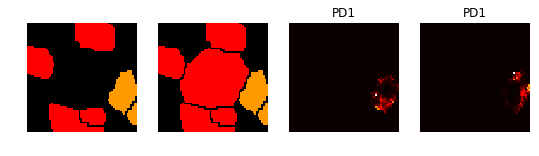

Significant Increase


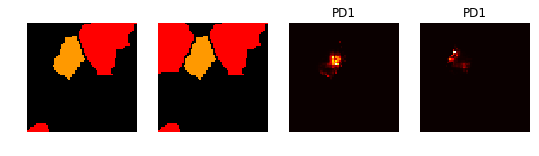

Significant Decrease


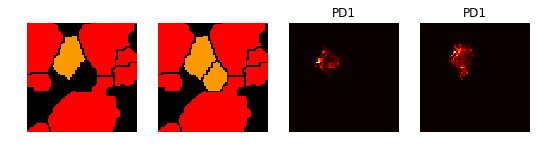

Significant Increase


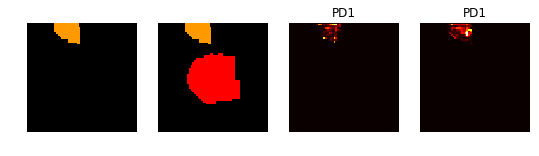

Significant Increase


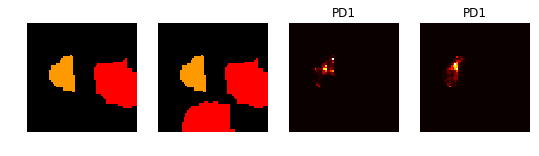

Significant Decrease


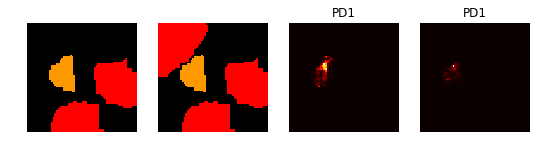

Significant Increase


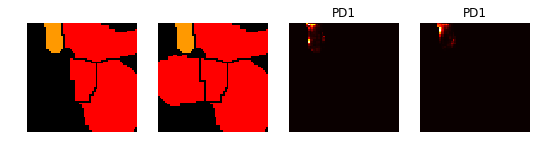

Significant Decrease


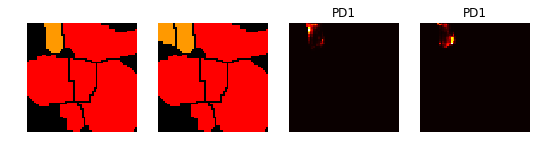

Significant Increase


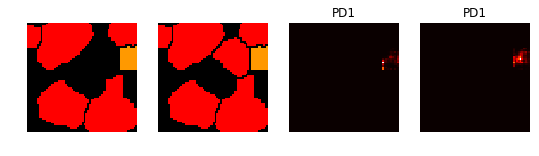

Significant Decrease


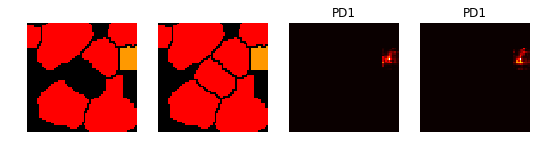

Significant Increase


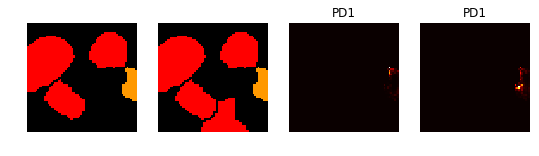

Significant Increase


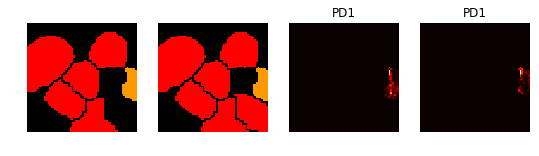

Significant Decrease


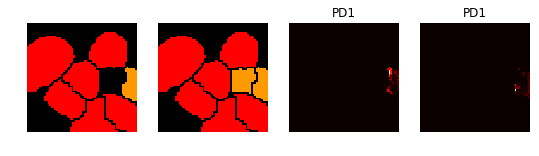

Significant Increase


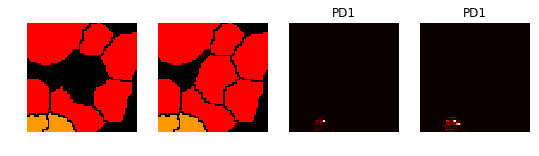

Significant Decrease


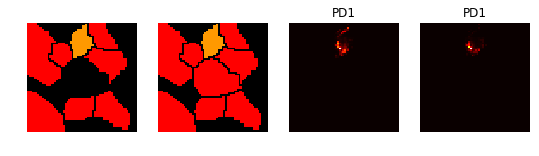

Significant Increase


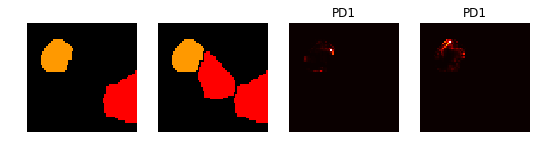

Significant Increase


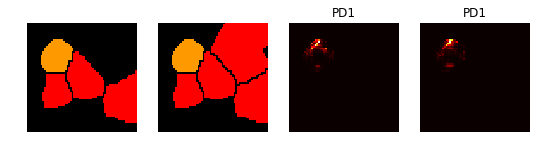

Significant Decrease


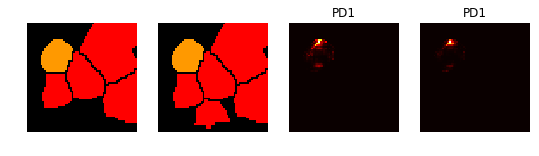

Significant Increase


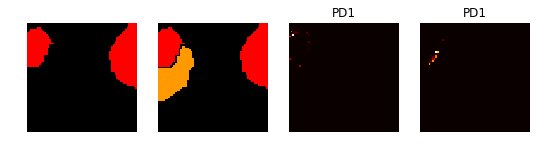

Significant Increase


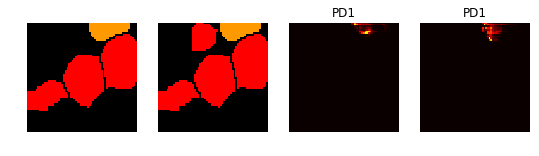

Significant Increase


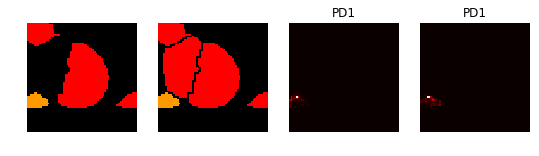

Significant Increase


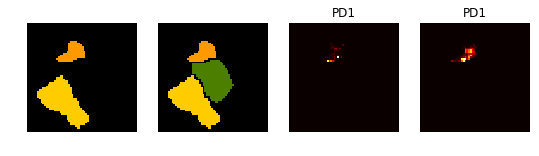

Significant Decrease


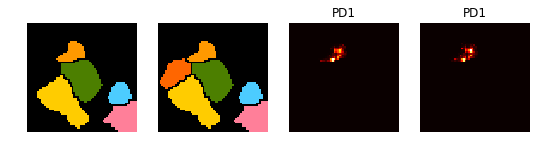

Significant Decrease


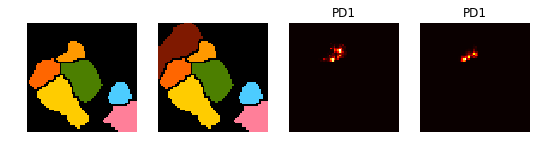

In [17]:
'''
Begin Search

specify: (channel_id, bar)

'''

channel_id =18
main_id = 0
for r in range(1):
    for i in range(len(cells_seg_list)):
        seg_list = cells_seg_list[i]
        search_cell(seg_list, main_id, channel_id, noise,  bar=0.0005)

# Reconstruction Metrics

# Adjust L1

In [ ]:
# Adjust L1

Loss = 0
AdjLoss  = 0
for idx, data in enumerate(test_set_loader):

    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()
    X_mask = (1 - X_seg[:,-1]).unsqueeze(1)
    noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
    fake = netG(noise, X_seg).detach()
    outside = (1 - X_mask) * fake
    
    B,C = X_real.size()[:2]
    real_data = (X_mask*X_real).view(B, C, -1)
    fake_data = (X_mask*fake).view(B, C, -1)
    # print(real_data.shape)
    
    real_rank, _ = torch.sort(real_data, dim=2)
    fake_rank, _ = torch.sort(fake_data, dim=2)
    
    Loss += nn.L1Loss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.L1Loss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.L1Loss()(outside[:], torch.zeros_like(outside[:]))
    
print('Adjust L1 Metric:', AdjLoss.item())
print('Pure L1 Metric:', Loss.item())

# Adjusted MSE

In [18]:
# Adjust MSE

Loss = 0
AdjLoss  = 0
for idx, data in enumerate(test_set_loader):

    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()
    X_mask = (1 - X_seg[:,-1]).unsqueeze(1)
    noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
    fake = netG(noise, X_seg).detach()
    outside = (1 - X_mask) * fake
    
    B,C = X_real.size()[:2]
    real_data = (X_mask*X_real).view(B, C, -1)
    fake_data = (X_mask*fake).view(B, C, -1)
    # print(real_data.shape)
    
    real_rank, _ = torch.sort(real_data, dim=2)
    fake_rank, _ = torch.sort(fake_data, dim=2)
    
    Loss += nn.MSELoss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.MSELoss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.MSELoss()(outside[:], torch.zeros_like(outside[:]))
    
print('Adjust MSE Metric:', AdjLoss.item())
print('Pure MSE Metric:', Loss.item())

Adjust MSE Metric: 0.026254907250404358
Pure MSE Metric: 0.02616511844098568


# SSIM

In [22]:
cells_seg_list = []
cells_real_list = []

download_path = './data/benchmark_p14'
filelist = os.listdir(download_path)

for i in range(len(filelist)):
    patch = download_path + '/cell_' + str(i) + '.npy'
    cells_seg_list.append(np.load(patch)[0])
    cells_real_list.append(np.load(patch)[1])

In [21]:
from skimage.measure import compare_ssim

ssim_score = 0
ssim_channels = np.zeros(nc)

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    # seg_test = 0
    seg_test = np.sum(seg_list, axis=0)
    empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_test_18 = np.concatenate([seg_test, empty], axis=0)
    X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
    
    # fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
    fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
    
    # fake = netF(fake, X_seg_0)
    for j in range(nc):
        fake_i = fake[j].astype(float)
        real_i = np.sum(real_list, axis=0)[j].astype(float)  # i-th cell, j-th channel

        # plt.imshow(fake_i)
        # plt.show()
        # plt.imshow(real_i)
        # plt.show()
        ssim_score += compare_ssim(fake_i, real_i)/nc
        ssim_channels[j] += compare_ssim(fake_i, real_i)

print('ssim score:', ssim_score/len(cells_seg_list))
for j in range(nc):
    print(channel_names[j], ssim_channels[j]/len(cells_seg_list))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


ssim score: 0.955164218665233
Pan-Keratin 0.8906516966066818
EGFR 0.9959004254633308
Beta catenin 0.8005639840229877
dsDNA 0.8202061395964431
Ki67 0.9916264602857635
CD3 0.9722234465039303
CD8 0.9696326452576417
CD4 0.9965524587838172
FoxP3 0.9998054709294971
MPO 0.9992360507609312
HLA-DR 0.979642540216024
HLA_Class_1 0.7451917381770891
CD209 0.9997566506324919
CD11b 0.9998261155502693
CD11c 0.9982090633205644
CD68 0.9921558403868845
CD63 0.9940159200014695
Lag3 0.9984667804721604
PD1 0.9789132390846947
PD-L1 0.8836419165946395
IDO 0.9991512470399059
Vimentin 0.9443916314822404
SMA 0.9754305818817104
CD31 0.9987492049143821


# Cell Based Mutual Information

In [15]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [17]:
total_mi = 0
n_bin = 50
mi_channels = np.zeros(nc)

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    # seg_test = 0
    seg_test = np.sum(seg_list, axis=0)
    empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_test_18 = np.concatenate([seg_test, empty], axis=0)
    X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
    
    fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
    
    for i in range(n_cell):
        mask = seg_list[i].sum(axis=0)
        
        for j in range(nc):
            fake_i = (fake*mask)[j].flatten()
            real_i = real_list[i][j].flatten()   # i-th cell, j-th channel

            hist_2d, _, _ = np.histogram2d(fake_i, real_i, bins=n_bin)

            mi = mutual_information(hist_2d)
            mi_channels[j] += mi/n_cell/nc
            total_mi += mi/n_cell/nc
            
print('mutual information:', total_mi)
for j in range(nc):
    print(channel_names[j], mi_channels[j])

mutual information: 10.45644743685693
Pan-Keratin 0.36098346920957985
EGFR 0.0007223936619312186
Beta catenin 0.46689492117368486
dsDNA 5.367115317604401
Ki67 0.009195963056598833
CD3 0.02721147291060109
CD8 0.08147430451170382
CD4 0.0022049578513495816
FoxP3 0.0
MPO 0.0016845337208012566
HLA-DR 0.14701313752069453
HLA_Class_1 3.6701828972184383
CD209 0.0
CD11b 0.0
CD11c 0.0032101154690480143
CD68 0.018388642458249106
CD63 0.012797257643545045
Lag3 0.0010277557953313132
PD1 0.013430568906299527
PD-L1 0.020205005356982268
IDO 0.0001632735784445872
Vimentin 0.2083809663633403
SMA 0.043834128630253995
CD31 0.0003263542157011176


# BIOLOGICAL SIGNIFICANCE

# Pan-Keratin/CD8 Experiment

In [ ]:
cells_seg_list = []
cells_real_list = []

download_path = './data/cd8_test_c24'
filelist = os.listdir(download_path)

for i in range(len(filelist)):
    patch = download_path + '/cell_' + str(i) + '.npy'
    cells_seg_list.append(np.load(patch)[0])
    cells_real_list.append(np.load(patch)[1])

In [54]:
# CD8 Test
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


surface_area = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    

    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        seg_cd8 = 0
        if k == 0:
            seg_test[7] =  0   # cd8
        else:
            seg_cd8 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[7] = seg_cd8    # cd8

        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum()/ seg_tumor.sum()
 
        surface_area.append(seg_cd8.sum())
        tumor_expression.append(pk_cur)
   #  print(surface_area)#

slope: -2.898325909410821e-06
r-square 0.10972895143658237
t-test -13.53346157037662
p-value 1.9426405182465423e-39


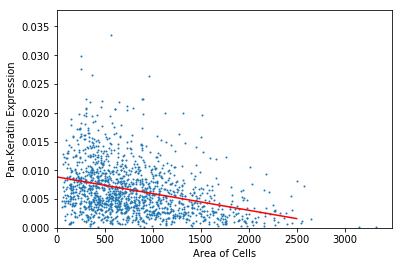

In [56]:
x = np.array(surface_area)
y = np.array(tumor_expression)

plt.xlabel('Area of Cells')
plt.ylabel('Pan-Keratin Expression')
plt.scatter(x,y,s=1)


from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x,y)
t = np.arange(0,2500)
y_t = slope*t + intercept


t_test = r_value*np.sqrt(x.shape[0]-2)/np.sqrt(1-r_value**2)
plt.plot(t,y_t,'r')
print('slope:', slope)
print('r-square', r_value**2)
print('t-test', t_test)
print('p-value', p_value)
plt.xlim(0)
plt.ylim(0)
plt.show()

In [57]:
# CD8 Test: Tumor Control
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


surface_area = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    
    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        seg_cd3 = 0
        if k>0:
            seg_cd3 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[4] += seg_cd3    # cd8
        
        
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum() / seg_tumor.sum()
 
        surface_area.append(seg_cd3.sum())
        tumor_expression.append(pk_cur)
        

slope: 3.6847662257152924e-07
r-square 0.0007456412232028974
t-test 1.0530193073717127
p-value 0.29250333555170804


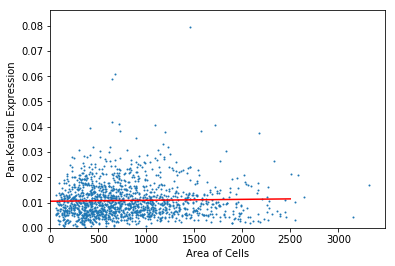

In [58]:
x = np.array(surface_area)
y = np.array(tumor_expression)

plt.xlabel('Area of Cells')
plt.ylabel('Pan-Keratin Expression')
plt.scatter(x,y,s=1)


from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x,y)
t = np.arange(0,2500)
y_t = slope*t + intercept


t_test = r_value*np.sqrt(x.shape[0]-2)/np.sqrt(1-r_value**2)
plt.plot(t,y_t,'r')
print('slope:', slope)
print('r-square', r_value**2)
print('t-test', t_test)
print('p-value', p_value)
plt.xlim(0)
plt.ylim(0)
plt.show()

In [23]:
# CD8 Test
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


cell_num = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    
    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        
        if k == 0:
            seg_test[7] =  0   # cd8
        else:
            seg_cd3 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[7] = seg_cd3    # cd8

        
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum()/seg_tumor.sum()
        
        cell_num.append(k)
        tumor_expression.append(pk_cur)
        

In [24]:
n_max = np.max(cell_num)
x_mean = np.zeros(n_max)
x_std = np.zeros(n_max)
for k in range(1, n_max):
    exp_k = []
    for i in range(len(cell_num)):
        if cell_num[i]==k:
            # print(k)
            exp_k.append(tumor_expression[i])
    x_mean[k-1] = np.mean(exp_k)
    x_std[k-1] = np.std(exp_k)

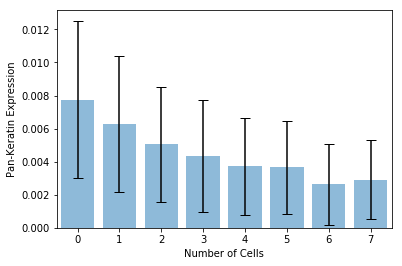

In [29]:
t = np.arange(n_max)
plt.xlabel('Number of Cells')
plt.ylabel('Pan-Keratin Expression')
plt.bar(t,x_mean, yerr=x_std, align='center', alpha=0.5, ecolor='black', capsize=5)
plt.xlim(-0.5,7.5)
plt.show()

In [30]:
# CD8 Test
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


cell_num = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    
    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        seg_cd3 = 0
        if k>0:
            seg_cd3 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[4] += seg_cd3    # cd8

        
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum()/seg_tumor.sum()
        
        cell_num.append(k)
        tumor_expression.append(pk_cur)
        

In [31]:
n_max = np.max(cell_num)
x_mean = np.zeros(n_max)
x_std = np.zeros(n_max)
for k in range(1, n_max+1):
    exp_k = []
    for i in range(len(cell_num)):
        if cell_num[i]==k:
            # print(k)
            exp_k.append(tumor_expression[i])
    x_mean[k-1] = np.mean(exp_k)
    x_std[k-1] = np.std(exp_k)

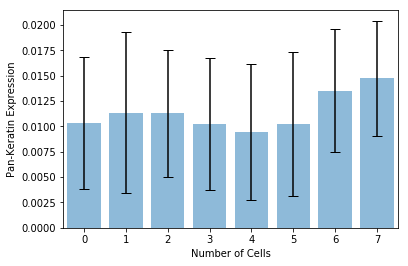

In [32]:
t = np.arange(n_max)
plt.xlabel('Number of Cells')
plt.ylabel('Pan-Keratin Expression')
plt.bar(t,x_mean, yerr=x_std, align='center', alpha=0.5, ecolor='black', capsize=5)
plt.xlim(-0.5,7.5)
plt.show()

# Center of Mass

In [ ]:
cells_seg_list = []
cells_real_list = []

download_path = './data/cd8_test_c24'
filelist = os.listdir(download_path)

for i in range(len(filelist)):
    patch = download_path + '/cell_' + str(i) + '.npy'
    cells_seg_list.append(np.load(patch)[0])
    cells_real_list.append(np.load(patch)[1])

In [33]:
cm_score = 0

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    xy = np.mgrid[0:64,0:64]
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    # seg_test = 0
    seg_test = np.sum(seg_list, axis=0)
    empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_test_18 = np.concatenate([seg_test, empty], axis=0)
    X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
    
    
    fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
    fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
    fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)    # only consider the expression in tumor cells

    cm_tumor_y = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
    cm_tumor_x = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
    cm_tumor = np.array([cm_tumor_x, cm_tumor_y])
    
    tcell_mask = seg_list[0].sum(axis=0)
    tcell_seg = np.array(np.where(tcell_mask==1))
    dist = np.linalg.norm(tcell_seg - cm_tumor[:, 19:20], axis=0)
    cm_idx = np.argmin(dist)
    cm_tumor_incell = tcell_seg[:, cm_idx]
    
    
    cm_tcell_y = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
    cm_tcell_x = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
    cm_tcell = np.array([cm_tcell_x, cm_tcell_y])

    
    cm_score += np.linalg.norm(cm_tcell[:,18] - cm_tumor_incell[:], ord=2)
    # cm_score += np.linalg.norm(cm_tcell[:,19] - cm_tumor[:,20], ord=2)
    
print('center of mass score:', cm_score / len(cells_seg_list))

center of mass score: 10.456068327507015


# Random COM

In [ ]:
cm_score = 0

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    xy = np.mgrid[0:64,0:64]
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    # seg_test = 0
    seg_test = np.sum(seg_list, axis=0)
    empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_test_18 = np.concatenate([seg_test, empty], axis=0)
    X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
    
    
    fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
    fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
    fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)    # only consider the expression in tumor cells

    cm_tumor_y = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
    cm_tumor_x = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
    cm_tumor = np.array([cm_tumor_x, cm_tumor_y])
    
    tcell_mask = seg_list[0].sum(axis=0)
    tcell_seg = np.array(np.where(tcell_mask==1))
    dist = np.linalg.norm(tcell_seg - cm_tumor[:, 19:20], axis=0)
    cm_idx = np.argmin(dist)
    cm_tumor_incell = tcell_seg[:, cm_idx]
    
    
    indices = np.where(tcell_mask > 0)
    upper = len(indices[0])
    idx_rand = np.random.randint(upper)
    cm_tcell_x = indices[0][idx_rand]
    cm_tcell_y = indices[1][idx_rand]
    
    cm_tcell = np.array([cm_tcell_x, cm_tcell_y])

    # cm_tcell_y = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
    # cm_tcell_x = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
    # cm_tcell = np.array([cm_tcell_x, cm_tcell_y])

    
    cm_score += np.linalg.norm(cm_tcell[:] - cm_tumor_incell[:], ord=2)
    # cm_score += np.linalg.norm(cm_tcell[:,19] - cm_tumor[:,20], ord=2)
    
print('center of mass score:', cm_score / len(cells_seg_list))

# EM Distance

In [12]:
from scipy.stats import wasserstein_distance

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi = 2*np.pi + phi
        
    return (rho, phi)


def compute_histogram(img, divider=30, size = 64, offset=32):

    histogram = np.zeros([divider])

    for i in range(size):
        for j in range(size):
            x = j - offset
            y = offset - i
            
            rho, phi = cart2pol(x,y)
            # normalize to [0,divider]
            degree = divider * phi/(2*np.pi) 
            index = int(np.floor(degree))
            histogram[index] += img[i,j]
            
    return histogram

# EMD score

In [16]:
# EM score threshold
em_score = 0
direct_right = 0
direct_wrong = 0
direct_all = 0

for c in range(len(cells_seg_list)):

    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    seg_test = 0
    xy = np.mgrid[0:64,0:64]
    centroids_seg = []
    centroids_tcell = []
    centroids_tumor = []
    express_tcell = []
    for i in range(n_cell):

        # non-weighted centroid of segmentation
        cy = np.where(seg_list[i]==1)[1].mean()
        cx = np.where(seg_list[i]==1)[2].mean()
        centroids_seg.append(np.array([cx, cy]))

        # weighted centroid of T cells
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
        fake_tumor = fake * seg_list[i].sum(axis=0)    # only consider the expression in tumor cells
        # fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)
        histo_cur = compute_histogram(fake_tcell[18])
        
        # weighted centroid of T cells
        cy_all = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        centroids_tcell.append(np.array([cx_all, cy_all]))

        
        # weighted centroid of tumor cells
        cy_all = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        centroids_tumor.append(np.array([cx_all, cy_all]))
        
        # print(fake_tumor[19].sum())
        
        if i > 0 and fake_tumor[19].sum() > 1e-4:
            
            direct_all += 1
            # the previous angle
            
            v1 = (centroids_tumor[i][:,19] - centroids_seg[0])    # previous centroid of T cell            
            v2 = (centroids_tcell[i][:,18] - centroids_tcell[i-1][:,18])    # current centroid of T cell
            
            if i == 1: # no work so much
                v2 = (centroids_tcell[i][:,18] - centroids_seg[0])
                
            cos_theta = np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2)
            
            em_dist = wasserstein_distance(histo_cur, histo_pre)
            
            
            if cos_theta > 0:
                direct_right += 1
                
            elif cos_theta < 0:
                direct_wrong += 1
                
            if cos_theta > 0 and histo_cur.sum() > histo_pre.sum():   # threshold the theta / check the expression level
                em_score +=  np.linalg.norm(v2) * em_dist
                
            elif cos_theta < 0:
                em_score -= np.linalg.norm(v2) * em_dist
        
        histo_pre = histo_cur.copy()  
        
print("Direction: right:{}, wrong:{}, total:{}".format(direct_right, direct_wrong, direct_all))

print("em_score:{}".format(em_score))

Direction: right:897, wrong:591, total:1488
em_score:151.56458221164277


# Positive EMD score

In [27]:
# EM score threshold
em_score = 0
direct_right = 0
direct_wrong = 0
direct_all = 0

for c in range(len(cells_seg_list)):

    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    seg_test = 0
    xy = np.mgrid[0:64,0:64]
    centroids_seg = []
    centroids_tcell = []
    centroids_tumor = []
    express_tcell = []
    for i in range(n_cell):

        # non-weighted centroid of segmentation
        cy = np.where(seg_list[i]==1)[1].mean()
        cx = np.where(seg_list[i]==1)[2].mean()
        centroids_seg.append(np.array([cx, cy]))

        # weighted centroid of T cells
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
        fake_tumor = fake * seg_list[i].sum(axis=0)    # only consider the expression in tumor cells
        # fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)
        histo_cur = compute_histogram(fake_tcell[18])
        
        # weighted centroid of T cells
        cy_all = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        centroids_tcell.append(np.array([cx_all, cy_all]))

        
        # weighted centroid of tumor cells
        cy_all = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        centroids_tumor.append(np.array([cx_all, cy_all]))
        
        # print(fake_tumor[19].sum())
        
        if i > 0 and fake_tumor[19].sum() > 1e-4:
            
            direct_all += 1
            # the previous angle
            
            v1 = (centroids_tumor[i][:,19] - centroids_seg[0])    # previous centroid of T cell            
            v2 = (centroids_tcell[i][:,18] - centroids_tcell[i-1][:,18])    # current centroid of T cell
            
            if i == 1: # no work so much
                v2 = (centroids_tcell[i][:,18] - centroids_seg[0])
                
            cos_theta = np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2)
            
            em_dist = wasserstein_distance(histo_cur, histo_pre)
            
            
            if cos_theta > 0:
                direct_right += 1
                
            elif cos_theta < 0:
                direct_wrong += 1
                
            if cos_theta > 0 and histo_cur.sum() > histo_pre.sum():   # threshold the theta / check the expression level
                em_score += np.linalg.norm(v2) * em_dist
                
            # elif cos_theta < 0:
            #     em_score -= np.linalg.norm(v2) * em_dist
        
        histo_pre = histo_cur.copy()  
        
print("Direction: right:{}, wrong:{}, total:{}".format(direct_right, direct_wrong, direct_all))

print("em_score:{}".format(em_score))

Direction: right:900, wrong:588, total:1488
em_score:278.3751922089376


# Projected EMD score

In [29]:
# EM score threshold
em_score = 0
direct_right = 0
direct_wrong = 0
direct_all = 0

for c in range(len(cells_seg_list)):

    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    seg_test = 0
    xy = np.mgrid[0:64,0:64]
    centroids_seg = []
    centroids_tcell = []
    centroids_tumor = []
    express_tcell = []
    for i in range(n_cell):

        # non-weighted centroid of segmentation
        cy = np.where(seg_list[i]==1)[1].mean()
        cx = np.where(seg_list[i]==1)[2].mean()
        centroids_seg.append(np.array([cx, cy]))

        # weighted centroid of T cells
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
        fake_tumor = fake * seg_list[i].sum(axis=0)    # only consider the expression in tumor cells
        # fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)
        histo_cur = compute_histogram(fake_tcell[18])
        
        # weighted centroid of T cells
        cy_all = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        centroids_tcell.append(np.array([cx_all, cy_all]))

        
        # weighted centroid of tumor cells
        cy_all = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        centroids_tumor.append(np.array([cx_all, cy_all]))
        
        # print(fake_tumor[19].sum())
        
        if i > 0 and fake_tumor[19].sum() > 1e-4:
            
            direct_all += 1
            # the previous angle
            
            v1 = (centroids_tumor[i][:,19] - centroids_seg[0])    # previous centroid of T cell            
            v2 = (centroids_tcell[i][:,18] - centroids_tcell[i-1][:,18])    # current centroid of T cell
            
            if i == 1: # no work so much
                v2 = (centroids_tcell[i][:,18] - centroids_seg[0])
                
            cos_theta = np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2)
            
            em_dist = wasserstein_distance(histo_cur, histo_pre)
            
            
            if cos_theta > 0:
                direct_right += 1
                
            elif cos_theta < 0:
                direct_wrong += 1
                
            if cos_theta > 0 and histo_cur.sum() > histo_pre.sum():   # threshold the theta / check the expression level
                em_score += cos_theta * np.linalg.norm(v2) * em_dist
                
            elif cos_theta < 0:
                em_score += cos_theta * np.linalg.norm(v2) * em_dist
        
        histo_pre = histo_cur.copy()  
        
print("Direction: right:{}, wrong:{}, total:{}".format(direct_right, direct_wrong, direct_all))

print("em_score:{}".format(em_score))

Direction: right:893, wrong:595, total:1488
em_score:115.77325869471024


# Control EMD score

In [17]:
# EM score threshold
em_score = 0
direct_right = 0
direct_wrong = 0
direct_all = 0

for c in range(len(cells_seg_list)):

    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    seg_test = 0
    xy = np.mgrid[0:64,0:64]
    centroids_seg = []
    centroids_tcell = []
    centroids_tumor = []
    express_tcell = []
    for i in range(n_cell):

        # non-weighted centroid of segmentation
        cy = np.where(seg_list[i]==1)[1].mean()
        cx = np.where(seg_list[i]==1)[2].mean()
        centroids_seg.append(np.array([cx, cy]))

        # weighted centroid of T cells
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        X_seg_0[0,1] = X_seg_0[0,4].clone()
        X_seg_0[0,4] = 0
        
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
        fake_tumor = fake * seg_list[i].sum(axis=0)    # only consider the expression in tumor cells
        # fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)
        
        
        
        histo_cur = compute_histogram(fake_tcell[18])
        
        # weighted centroid of T cells
        cy_all = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        centroids_tcell.append(np.array([cx_all, cy_all]))

        
        # weighted centroid of tumor cells
        cy_all = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        centroids_tumor.append(np.array([cx_all, cy_all]))
        
        # print(fake_tumor[19].sum())
        
        if i > 0 and fake_tumor[19].sum() > 1e-4:
            
            direct_all += 1
            # the previous angle
            
            v1 = (centroids_tumor[i][:,19] - centroids_seg[0])    # previous centroid of T cell            
            v2 = (centroids_tcell[i][:,18] - centroids_tcell[i-1][:,18])    # current centroid of T cell
            
            if i == 1: # no work so much
                v2 = (centroids_tcell[i][:,18] - centroids_seg[0])
                
            cos_theta = np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2)
            
            em_dist = wasserstein_distance(histo_cur, histo_pre)
            
            
            if cos_theta > 0:
                direct_right += 1
                
            elif cos_theta < 0:
                direct_wrong += 1
                
            if cos_theta > 0 and histo_cur.sum() > histo_pre.sum():   # threshold the theta / check the expression level
                em_score += np.linalg.norm(v2) * em_dist
                
            elif cos_theta < 0:
                em_score -= np.linalg.norm(v2) * em_dist
            
        histo_pre = histo_cur.copy()
        
print("Direction: right:{}, wrong:{}, total:{}".format(direct_right, direct_wrong, direct_all))
    
print("em_score:{}".format(em_score))

Direction: right:908, wrong:578, total:1486
em_score:-22.682939554136983


# Control Positive EMD score

In [18]:
# EM score threshold
em_score = 0
direct_right = 0
direct_wrong = 0
direct_all = 0

for c in range(len(cells_seg_list)):

    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    seg_test = 0
    xy = np.mgrid[0:64,0:64]
    centroids_seg = []
    centroids_tcell = []
    centroids_tumor = []
    express_tcell = []
    for i in range(n_cell):

        # non-weighted centroid of segmentation
        cy = np.where(seg_list[i]==1)[1].mean()
        cx = np.where(seg_list[i]==1)[2].mean()
        centroids_seg.append(np.array([cx, cy]))

        # weighted centroid of T cells
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        X_seg_0[0,1] = X_seg_0[0,4].clone()
        X_seg_0[0,4] = 0
        
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
        fake_tumor = fake * seg_list[i].sum(axis=0)    # only consider the expression in tumor cells
        # fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)
        
        
        
        histo_cur = compute_histogram(fake_tcell[18])
        
        # weighted centroid of T cells
        cy_all = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        centroids_tcell.append(np.array([cx_all, cy_all]))

        
        # weighted centroid of tumor cells
        cy_all = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        centroids_tumor.append(np.array([cx_all, cy_all]))
        
        # print(fake_tumor[19].sum())
        
        if i > 0 and fake_tumor[19].sum() > 1e-4:
            
            direct_all += 1
            # the previous angle
            
            v1 = (centroids_tumor[i][:,19] - centroids_seg[0])    # previous centroid of T cell            
            v2 = (centroids_tcell[i][:,18] - centroids_tcell[i-1][:,18])    # current centroid of T cell
            
            if i == 1: # no work so much
                v2 = (centroids_tcell[i][:,18] - centroids_seg[0])
                
            cos_theta = np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2)
            
            em_dist = wasserstein_distance(histo_cur, histo_pre)
            
            
            if cos_theta > 0:
                direct_right += 1
                
            elif cos_theta < 0:
                direct_wrong += 1
                
            if cos_theta > 0 and histo_cur.sum() > histo_pre.sum():   # threshold the theta / check the expression level
                em_score += np.linalg.norm(v2) * em_dist
                
            # elif cos_theta < 0:
            #     em_score -= np.linalg.norm(v2) * em_dist
            
        histo_pre = histo_cur.copy()
        
print("Direction: right:{}, wrong:{}, total:{}".format(direct_right, direct_wrong, direct_all))
    
print("em_score:{}".format(em_score))

Direction: right:894, wrong:592, total:1486
em_score:35.92241233849195


# Random EMD score

In [14]:
# EM score threshold
em_score = 0
direct_right = 0
direct_wrong = 0
direct_all = 0

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    seg_test = 0
    xy = np.mgrid[0:64,0:64]
    centroids_seg = []
    centroids_tcell = []
    centroids_tumor = []
    express_tcell = []
    for i in range(n_cell):

        # non-weighted centroid of segmentation
        cy = np.where(seg_list[i]==1)[1].mean()
        cx = np.where(seg_list[i]==1)[2].mean()
        centroids_seg.append(np.array([cx, cy]))

        # weighted centroid of T cells
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        X_seg_0[0,1] = X_seg_0[0,4].clone()
        X_seg_0[0,4] = 0
        
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        
        fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
        fake_tumor = fake * seg_list[i].sum(axis=0)    # only consider the expression in tumor cells
        # fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)
        tcell_mask = seg_list[0].sum(axis=0)
        
        histo_cur = compute_histogram(fake_tcell[18])
        
        # weighted centroid of T cells
        
        indices = np.where(tcell_mask > 0)
        upper = len(indices[0])
        idx_rand = np.random.randint(upper)
        cm_tcell_x = indices[0][idx_rand]
        cm_tcell_y = indices[1][idx_rand]
        
        centroids_tcell.append(np.array([cm_tcell_x, cm_tcell_y]))
        
        
        histo_cur = compute_histogram(fake_tcell[18])
        
        # weighted centroid of T cells
        # cy_all = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        # cx_all = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        # centroids_tcell.append(np.array([cx_all, cy_all]))

        
        # weighted centroid of tumor cells
        cy_all = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        centroids_tumor.append(np.array([cx_all, cy_all]))
        
        # print(fake_tumor[19].sum())
        
        if i > 0 and fake_tumor[19].sum() > 1e-4:
            
            direct_all += 1
            # the previous angle
            
            v1 = (centroids_tumor[i][:,19] - centroids_seg[0])    # previous centroid of T cell            
            v2 = (centroids_tcell[i][:] - centroids_tcell[i-1][:])    # current centroid of T cell
            
            if i == 1: # no work so much
                v2 = (centroids_tcell[i][:] - centroids_seg[0])
                
            cos_theta = np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2)
            
            em_dist = wasserstein_distance(histo_cur, histo_pre)
            
            
            if cos_theta > 0:
                direct_right += 1
                
            elif cos_theta < 0:
                direct_wrong += 1
                
            if cos_theta > 0 and histo_cur.sum() > histo_pre.sum():   # threshold the theta / check the expression level
                em_score +=  np.linalg.norm(v2) * em_dist
                
            elif cos_theta < 0:
                em_score -= np.linalg.norm(v2) * em_dist
            
        histo_pre = histo_cur.copy()
        
print("Direction: right:{}, wrong:{}, total:{}".format(direct_right, direct_wrong, direct_all))
    
print("em_score:{}".format(em_score))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in double_scalars


Direction: right:741, wrong:742, total:1486
em_score:-123.42988756358535


# Visualization for PD-1/PD-L1 Experiment

278


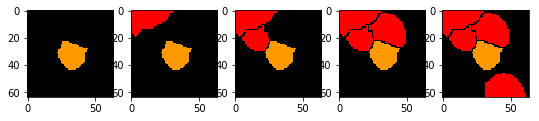

Fake


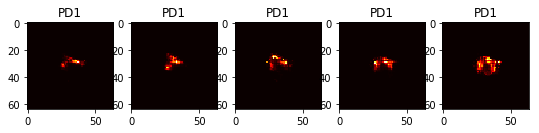

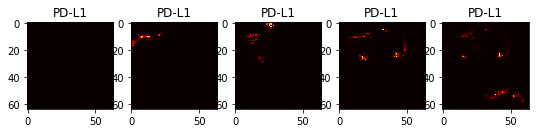

310


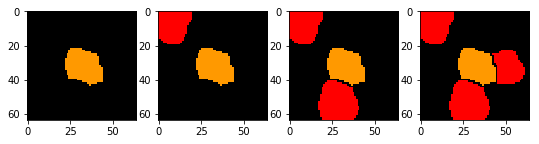

Fake


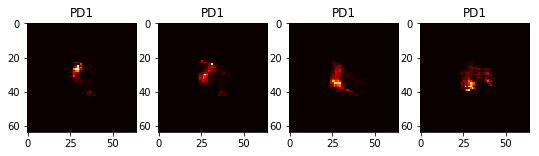

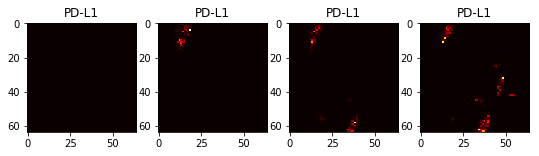

331


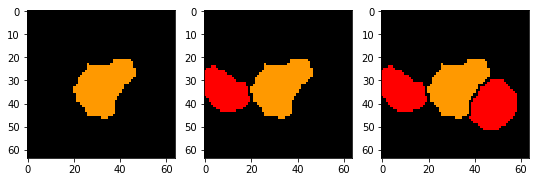

Fake


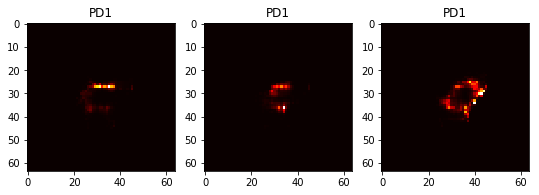

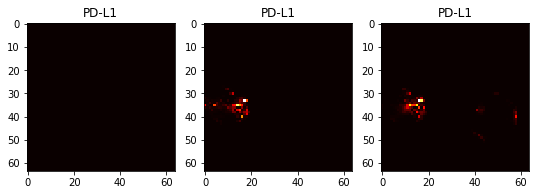

365


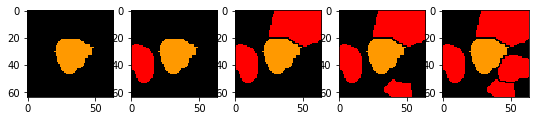

Fake


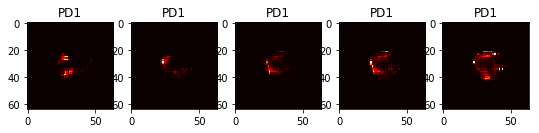

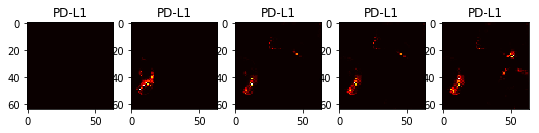

In [49]:
# green is immune,  red is tumor
seg_test = 0
real_test = 0

for test_id in list([278,310,331,365]):
    print(test_id)
    seg_list = cells_seg_list[test_id]
    real_list = cells_real_list[test_id]
    n_cell = len(seg_list)
    
    
    
    fig=plt.figure(figsize=(9,3))
    columns = len(seg_list)
    rows = 1
    im = 0
    centroids_seg = []
    
    for i in range(n_cell):
        fig.add_subplot(rows, columns, i+1)
        im += seg_list[i]
        
        plt.imshow(seg_show(im), cmap='hot', interpolation='nearest')
        
    plt.show()
    
    
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    
    print('Fake')
    
    seg_test = 0
    
    fig=plt.figure(figsize=(9,3))
    columns = len(seg_list)
    rows = 1
    xy = np.mgrid[0:64, 0:64]
    centroids_cell = []
    
    
    for i in range(n_cell):
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        
        
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        fake = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
    
        
        # print(fake[18].sum())
    
    
        fig.add_subplot(rows, columns, i+1)
        plt.title(channel_names[18])
        plt.imshow(fake[18], cmap='hot', interpolation='nearest')
        # plt.scatter(cx_all[18], cy_all[18], color='c')
        
    plt.show()
    
    
    
    seg_test = 0
    
    fig=plt.figure(figsize=(9,3))
    columns = len(seg_list)
    rows = 1
    xy = np.mgrid[0:64, 0:64]
    centroids_cell = []
    
    
    for i in range(n_cell):
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)
        # fake_tumor = fake * seg_list[i].sum(axis=0)
        
    
                
        fig.add_subplot(rows, columns, i+1)
        plt.title(channel_names[19])
        plt.imshow(fake_tumor[19], cmap='hot', interpolation='nearest')
    plt.show()
    

278


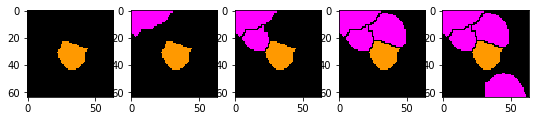

Fake


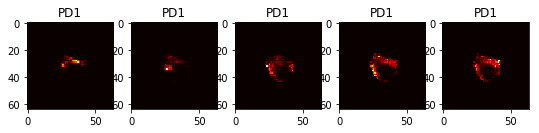

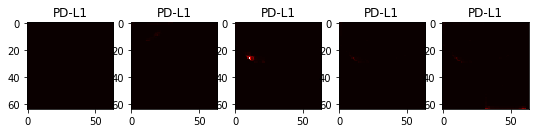

310


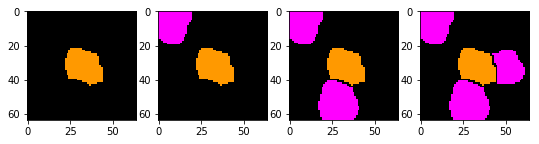

Fake


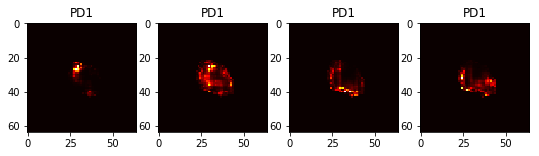

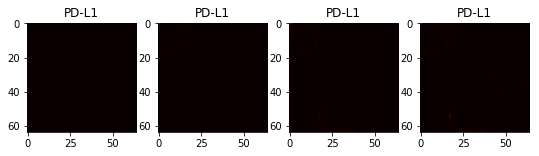

331


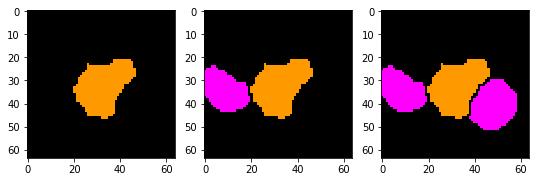

Fake


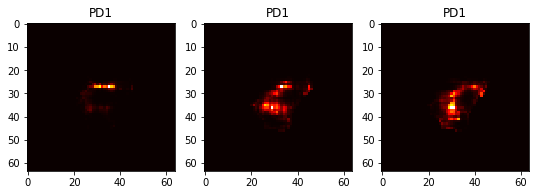

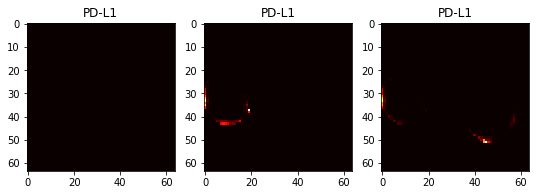

365


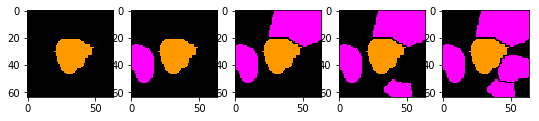

Fake


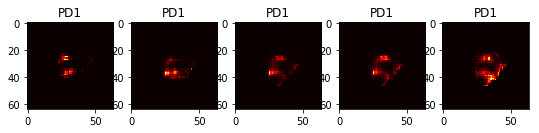

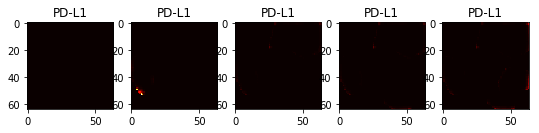

In [53]:
# green is immune,  red is tumor
seg_test = 0
real_test = 0

for test_id in list([278, 310, 331, 365]):
    print(test_id)
    seg_list = cells_seg_list[test_id]
    real_list = cells_real_list[test_id]
    n_cell = len(seg_list)
    
    
    fig=plt.figure(figsize=(9,3))
    columns = len(seg_list)
    rows = 1
    im = 0
    centroids_seg = []
    
    for i in range(n_cell):
        fig.add_subplot(rows, columns, i+1)
        im += seg_list[i]
        
        
        im[1] += im[4].copy()
        im[4] = 0
        
        plt.imshow(seg_show(im), cmap='hot', interpolation='nearest')
        
        
        
    plt.show()
    
    
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    
    print('Fake')
    
    seg_test = 0
    
    fig=plt.figure(figsize=(9,3))
    columns = len(seg_list)
    rows = 1
    xy = np.mgrid[0:64, 0:64]
    centroids_cell = []
    
    
    for i in range(n_cell):
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        
        X_seg_0[0,1] = X_seg_0[0,4].clone()
        X_seg_0[0,4] = 0
        
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        fake = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
    
        
        # print(fake[18].sum())
    
    
        fig.add_subplot(rows, columns, i+1)
        plt.title(channel_names[18])
        plt.imshow(fake[18], cmap='hot', interpolation='nearest')
        # plt.scatter(cx_all[18], cy_all[18], color='c')
        
    plt.show()
    
    
    
    seg_test = 0
    
    fig=plt.figure(figsize=(9,3))
    columns = len(seg_list)
    rows = 1
    xy = np.mgrid[0:64, 0:64]
    centroids_cell = []
    
    
    for i in range(n_cell):
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        X_seg_0[0,1] = X_seg_0[0,4].clone()
        X_seg_0[0,4] = 0
        fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
        fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)
        # fake_tumor = fake * seg_list[i].sum(axis=0)
    
        fig.add_subplot(rows, columns, i+1)
        plt.title(channel_names[19])
        plt.imshow(fake_tumor[19], cmap='hot', interpolation='nearest')
    plt.show()
    